In [2]:
import pandas as pd

import bz2
 
# === Load the dataset from test.ft.txt.bz2 ===

data_path = '/kaggle/input/amazonreviews/train.ft.txt.bz2'
 
# Read and parse bz2 file line by line

with bz2.open(data_path, 'rt') as f:

    lines = f.readlines()
 
# === Convert to DataFrame ===

texts = []

labels = []
 
for line in lines:

    label, text = line.split(" ", 1)

    binary_label = 1 if label.strip() == '__label__2' else 0

    labels.append(binary_label)

    texts.append(text.strip())
 
df = pd.DataFrame({'tweet_text': texts, 'label': labels})
 
# === Display class distribution ===

print(df['label'].value_counts())
 
# === Check for nulls and fill if needed ===

print(df.isnull().sum())

if df['tweet_text'].isnull().sum() > 0:

    fallback = df['tweet_text'].mode()[0] if not df['tweet_text'].mode().empty else "No text available"

    df['tweet_text'].fillna(fallback, inplace=True)

 

label
1    1800000
0    1800000
Name: count, dtype: int64
tweet_text    0
label         0
dtype: int64


# *Bert***

2025-06-17 15:03:46.317809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750172626.728525      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750172626.849905      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Balanced class counts:
label
0    5000
1    5000
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 438/438 [02:56<00:00,  2.48it/s]


Epoch 1: Train Loss=0.2424, Val Loss=0.2227, Train Acc=0.9006, Val Acc=0.9210


Epoch 2: 100%|██████████| 438/438 [03:05<00:00,  2.36it/s]


Epoch 2: Train Loss=0.0962, Val Loss=0.2238, Train Acc=0.9696, Val Acc=0.9330


Epoch 3: 100%|██████████| 438/438 [03:05<00:00,  2.36it/s]


Epoch 3: Train Loss=0.0505, Val Loss=0.2415, Train Acc=0.9870, Val Acc=0.9290


Epoch 4: 100%|██████████| 438/438 [03:05<00:00,  2.36it/s]


Epoch 4: Train Loss=0.0305, Val Loss=0.2769, Train Acc=0.9916, Val Acc=0.9290


Epoch 5: 100%|██████████| 438/438 [03:05<00:00,  2.36it/s]


Epoch 5: Train Loss=0.0261, Val Loss=0.2437, Train Acc=0.9929, Val Acc=0.9310


Epoch 6: 100%|██████████| 438/438 [03:05<00:00,  2.36it/s]


Epoch 6: Train Loss=0.0169, Val Loss=0.3313, Train Acc=0.9953, Val Acc=0.9260
Early stopping

Final Test Metrics:
Accuracy: 0.9230
Precision: 0.8895
Recall: 0.9660
F1-Score: 0.9262
MCC: 0.8491
MAE: 0.0770
MSE: 0.0770
RMSE: 0.2775
Cohen's Kappa: 0.8460
AUC-ROC: 0.9776
CSI: 0.8625


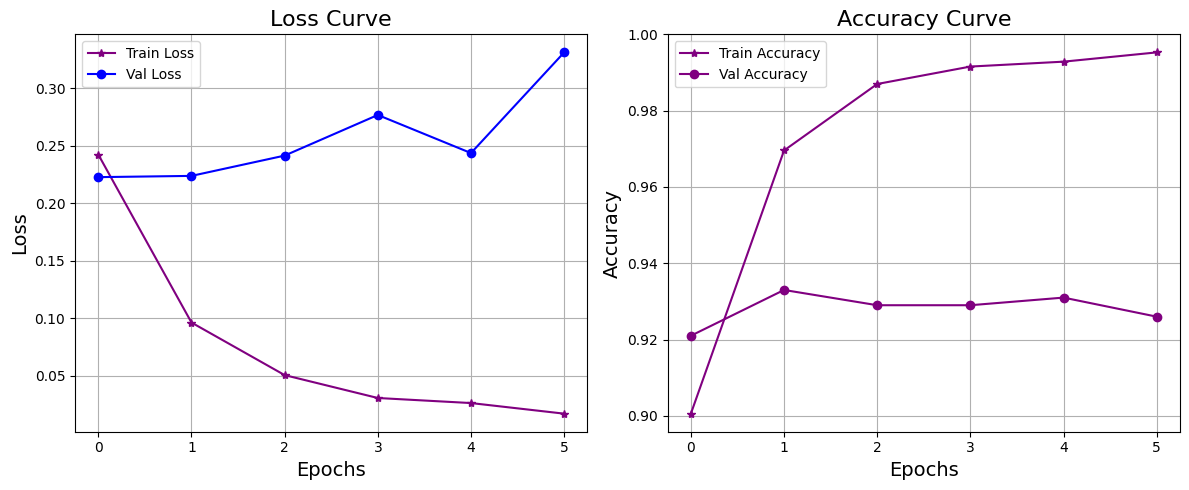

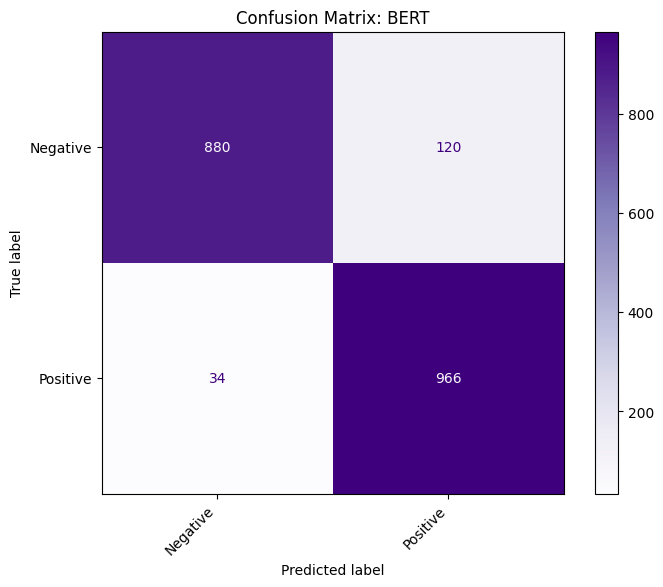

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_recall_fscore_support, matthews_corrcoef,
    mean_absolute_error, mean_squared_error,
    cohen_kappa_score, roc_auc_score
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
 
# === 1. Balance dataset by downsampling to 5k/class ===
sample_size = 5000
balanced_df = pd.concat([
    df[df['label'] == cls].sample(sample_size, random_state=42)
    for cls in df['label'].unique()
]).sample(frac=1, random_state=42).reset_index(drop=True)
 
print("Balanced class counts:")
print(balanced_df['label'].value_counts())
 
# === 2. Split into 70% train, 20% test, 10% val ===
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    balanced_df['tweet_text'], balanced_df['label'],
    test_size=0.3, stratify=balanced_df['label'], random_state=42
)
 
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=2/3, stratify=temp_labels, random_state=42
)
 
# === 3. Tokenization ===
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
 
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
 
    def __len__(self):
        return len(self.labels)
 
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
 
train_dataset = TweetDataset(train_texts, train_labels, tokenizer)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer)
 
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)
 
# === 4. Model Setup ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
 
# === 5. Training ===
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
best_val_loss = float('inf')
patience = 5
num_epochs = 30
trigger_times = 0
 
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
 
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()
 
        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).sum().item()
 
    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / len(train_dataset)
 
    model.eval()
    val_loss = 0
    correct_val = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_val += (preds == labels).sum().item()
 
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val / len(val_dataset)
 
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
 
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
 
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping")
            break
 
# === 6. Load Best Model and Evaluate ===
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds, all_labels, all_probs = [], [], []
 
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]
        preds = torch.argmax(outputs.logits, dim=1)
 
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
 
# === 7. Metrics ===
test_acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
mcc = matthews_corrcoef(all_labels, all_preds)
mae = mean_absolute_error(all_labels, all_preds)
mse = mean_squared_error(all_labels, all_preds)
rmse = np.sqrt(mse)
kappa = cohen_kappa_score(all_labels, all_preds)
auc_roc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, all_preds)
TP = cm[1,1]
FN = cm[1,0]
FP = cm[0,1]
CSI = TP / (TP + FN + FP) if (TP + FN + FP) > 0 else 0
 
print("\nFinal Test Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"CSI: {CSI:.4f}")
 
# === 8. Plot Loss and Accuracy Curves ===
plt.figure(figsize=(12, 5))
 
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss', color='purple', marker='*')
plt.plot(val_loss_list, label='Val Loss', color='blue', marker='o')
plt.title("Loss Curve", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.legend()
 
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy', color='purple', marker='*')
plt.plot(val_acc_list, label='Val Accuracy', color='purple', marker='o')
plt.title("Accuracy Curve", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True)
plt.legend()
 
plt.tight_layout()
plt.savefig('Bert1_training_curves.png', dpi=300)
plt.show()
 
# === 9. Confusion Matrix ===
labels = ['Negative', 'Positive']
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Purples, values_format='d')
plt.title('Confusion Matrix: BERT', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.rcParams.update({'font.size': 16})
plt.savefig('confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# Roberta****

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 438/438 [03:05<00:00,  2.36it/s]


Epoch 1: Train Loss=0.2429, Val Loss=0.1664, Train Acc=0.9044, Val Acc=0.9420


Epoch 2: 100%|██████████| 438/438 [03:05<00:00,  2.36it/s]


Epoch 2: Train Loss=0.1174, Val Loss=0.1861, Train Acc=0.9596, Val Acc=0.9440


Epoch 3: 100%|██████████| 438/438 [03:05<00:00,  2.36it/s]


Epoch 3: Train Loss=0.0812, Val Loss=0.1995, Train Acc=0.9743, Val Acc=0.9390


Epoch 4: 100%|██████████| 438/438 [03:04<00:00,  2.37it/s]


Epoch 4: Train Loss=0.0579, Val Loss=0.1920, Train Acc=0.9827, Val Acc=0.9510


Epoch 5: 100%|██████████| 438/438 [03:04<00:00,  2.37it/s]


Epoch 5: Train Loss=0.0321, Val Loss=0.1705, Train Acc=0.9910, Val Acc=0.9460


Epoch 6: 100%|██████████| 438/438 [03:05<00:00,  2.36it/s]


Epoch 6: Train Loss=0.0288, Val Loss=0.2508, Train Acc=0.9903, Val Acc=0.9390
Early stopping

Final Test Metrics:
Accuracy: 0.9340
Precision: 0.9438
Recall: 0.9230
F1-Score: 0.9333
MCC: 0.8682
MAE: 0.0660
MSE: 0.0660
RMSE: 0.2569
Cohen's Kappa: 0.8680
AUC-ROC: 0.9805
CSI: 0.8749


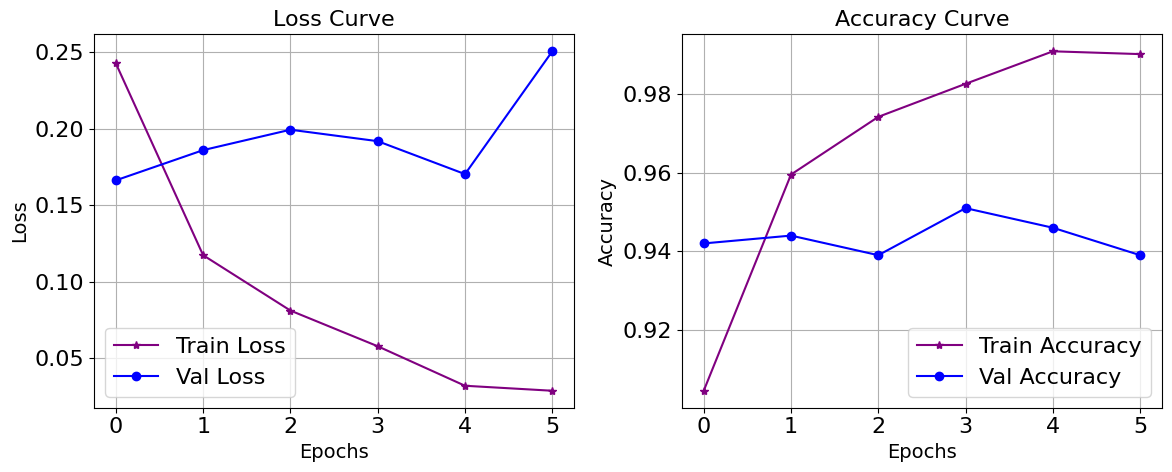

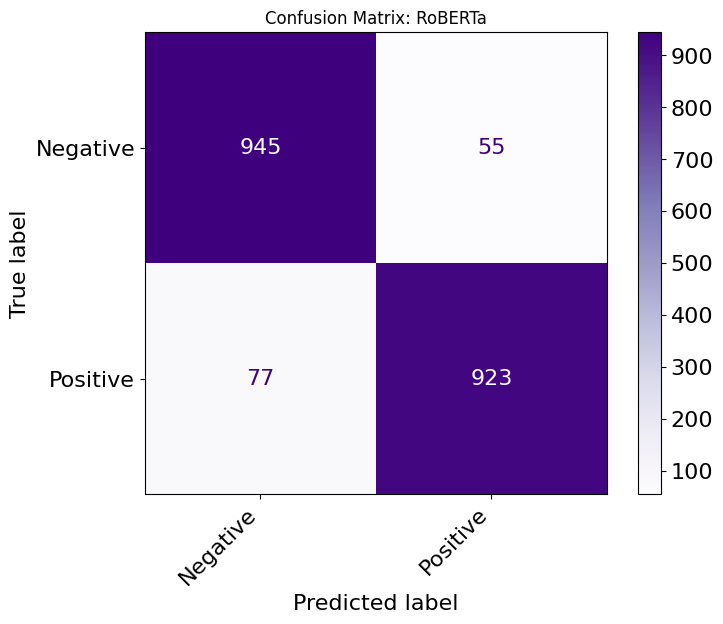

In [5]:
import torch

import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from transformers import RobertaTokenizer, RobertaForSequenceClassification

from torch.optim import AdamW

from sklearn.model_selection import train_test_split

from sklearn.metrics import (

    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,

    precision_recall_fscore_support, matthews_corrcoef,

    mean_absolute_error, mean_squared_error,

    cohen_kappa_score, roc_auc_score

)

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from tqdm import tqdm
 
# === 1. Balance dataset to exactly 5000 per class ===

sample_size = 5000

balanced_df = pd.concat([

    df[df['label'] == cls].sample(sample_size, random_state=42)

    for cls in df['label'].unique()

]).sample(frac=1, random_state=42).reset_index(drop=True)
 
# === 2. Split into train/val/test (70/10/20) ===

train_texts, temp_texts, train_labels, temp_labels = train_test_split(

    balanced_df['tweet_text'], balanced_df['label'],

    test_size=0.3, stratify=balanced_df['label'], random_state=42

)

val_texts, test_texts, val_labels, test_labels = train_test_split(

    temp_texts, temp_labels,

    test_size=2/3, stratify=temp_labels, random_state=42

)
 
# === 3. Tokenization ===

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
 
class TweetDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_len=128):

        self.texts = texts.tolist()

        self.labels = labels.tolist()

        self.tokenizer = tokenizer

        self.max_len = max_len
 
    def __len__(self):

        return len(self.labels)
 
    def __getitem__(self, idx):

        encoding = self.tokenizer(

            self.texts[idx],

            truncation=True,

            max_length=self.max_len,

            padding='max_length',

            return_tensors='pt'

        )

        return {

            'input_ids': encoding['input_ids'].squeeze(0),

            'attention_mask': encoding['attention_mask'].squeeze(0),

            'labels': torch.tensor(self.labels[idx], dtype=torch.long)

        }
 
train_dataset = TweetDataset(train_texts, train_labels, tokenizer)

val_dataset = TweetDataset(val_texts, val_labels, tokenizer)

test_dataset = TweetDataset(test_texts, test_labels, tokenizer)
 
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=16)

test_loader = DataLoader(test_dataset, batch_size=16)
 
# === 4. Model Setup ===

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
 
# === 5. Training ===

train_loss_list, val_loss_list = [], []

train_acc_list, val_acc_list = [], []

best_val_loss = float('inf')

patience = 5

num_epochs = 30

trigger_times = 0
 
for epoch in range(num_epochs):

    model.train()

    total_train_loss = 0

    correct_train = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):

        input_ids = batch['input_ids'].to(device)

        attention_mask = batch['attention_mask'].to(device)

        labels = batch['labels'].to(device)
 
        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss

        logits = outputs.logits

        loss.backward()

        optimizer.step()
 
        total_train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)

        correct_train += (preds == labels).sum().item()
 
    avg_train_loss = total_train_loss / len(train_loader)

    train_acc = correct_train / len(train_dataset)
 
    model.eval()

    val_loss = 0

    correct_val = 0

    with torch.no_grad():

        for batch in val_loader:

            input_ids = batch['input_ids'].to(device)

            attention_mask = batch['attention_mask'].to(device)

            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)

            correct_val += (preds == labels).sum().item()
 
    avg_val_loss = val_loss / len(val_loader)

    val_acc = correct_val / len(val_dataset)
 
    train_loss_list.append(avg_train_loss)

    val_loss_list.append(avg_val_loss)

    train_acc_list.append(train_acc)

    val_acc_list.append(val_acc)
 
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
 
    if avg_val_loss < best_val_loss:

        best_val_loss = avg_val_loss

        trigger_times = 0

        torch.save(model.state_dict(), 'best_roberta.pth')

    else:

        trigger_times += 1

        if trigger_times >= patience:

            print("Early stopping")

            break
 
# === 6. Load Best Model and Evaluate ===

model.load_state_dict(torch.load('best_roberta.pth'))

model.eval()

all_preds, all_labels, all_probs = [], [], []
 
with torch.no_grad():

    for batch in test_loader:

        input_ids = batch['input_ids'].to(device)

        attention_mask = batch['attention_mask'].to(device)

        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        probs = torch.softmax(outputs.logits, dim=1)[:, 1]

        preds = torch.argmax(outputs.logits, dim=1)
 
        all_preds.extend(preds.cpu().numpy())

        all_labels.extend(labels.cpu().numpy())

        all_probs.extend(probs.cpu().numpy())
 
# === 7. Metrics ===

test_acc = accuracy_score(all_labels, all_preds)

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

mcc = matthews_corrcoef(all_labels, all_preds)

mae = mean_absolute_error(all_labels, all_preds)

mse = mean_squared_error(all_labels, all_preds)

rmse = np.sqrt(mse)

kappa = cohen_kappa_score(all_labels, all_preds)

auc_roc = roc_auc_score(all_labels, all_probs)

cm = confusion_matrix(all_labels, all_preds)

TP = cm[1,1]

FN = cm[1,0]

FP = cm[0,1]

CSI = TP / (TP + FN + FP) if (TP + FN + FP) > 0 else 0
 
print("\nFinal Test Metrics:")

print(f"Accuracy: {test_acc:.4f}")

print(f"Precision: {precision:.4f}")

print(f"Recall: {recall:.4f}")

print(f"F1-Score: {f1:.4f}")

print(f"MCC: {mcc:.4f}")

print(f"MAE: {mae:.4f}")

print(f"MSE: {mse:.4f}")

print(f"RMSE: {rmse:.4f}")

print(f"Cohen's Kappa: {kappa:.4f}")

print(f"AUC-ROC: {auc_roc:.4f}")

print(f"CSI: {CSI:.4f}")
 
# === 8. Plot Loss and Accuracy Curves ===

plt.figure(figsize=(12, 5))
 
# Loss

plt.subplot(1, 2, 1)

plt.plot(train_loss_list, label='Train Loss', color='purple', marker='*')

plt.plot(val_loss_list, label='Val Loss', color='blue', marker='o')

plt.title("Loss Curve", fontsize=16)

plt.xlabel("Epochs", fontsize=14)

plt.ylabel("Loss", fontsize=14)

plt.grid(True)

plt.legend()
 
# Accuracy

plt.subplot(1, 2, 2)

plt.plot(train_acc_list, label='Train Accuracy', color='purple', marker='*')

plt.plot(val_acc_list, label='Val Accuracy', color='blue', marker='o')

plt.title("Accuracy Curve", fontsize=16)

plt.xlabel("Epochs", fontsize=14)

plt.ylabel("Accuracy", fontsize=14)

plt.grid(True)

plt.legend()
 
plt.tight_layout()

plt.savefig('/kaggle/working/roberta_training_curves.png', dpi=300)

plt.show()
 
# === 9. Confusion Matrix ===

labels = ['Negative', 'Positive']

conf_matrix = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
 
fig, ax = plt.subplots(figsize=(8, 6))

disp.plot(ax=ax, cmap=plt.cm.Purples, values_format='d')

plt.title('Confusion Matrix: RoBERTa', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.rcParams.update({'font.size': 16})

plt.savefig('/kaggle/working/roberta_confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')

plt.show()